In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def convert(filename, delimiter=",", print_intermediate=True):
    """
    Returns a tuple with the dataframe and the column names
    """
    # Get dataframe and headers from csv
    df = pd.read_csv(filename, delimiter,header=0)
    header_list = list(df.columns)

    if print_intermediate:
        # Print what we got
        print("\nObtained a dataframe with the following fields:")
        print("\n", df.dtypes, "\n")
        print("\nDataframe description:")
        print("#"*100+"\n", df, "\n"+"#"*100+"\n")
        print("\nHeaders:")
        print("#"*100,"\n", header_list, "\n"+"#"*100+"\n")

    return (df, header_list)

FILENAME = "nyt_ts.csv"
intermediate = convert(FILENAME, ",", False)
election_df = intermediate[0]
headers = intermediate[1]

In [3]:
# Convert strings representing datetime objects to datetime objects

def clean_column(df, column_name, error_values=[999]):
    """
    error_values is a list to be removed from column df[column_name]
    returns a dataframe with just one column
    """
    column = list(df[column_name][~df[column_name].isin(error_values)])
    # Creating a new dataframe
    cleaned = pd.DataFrame({column_name: column})

    return cleaned


def getdatetimes(df, 
                 column_name, 
                 format = '%Y-%m-%d %H:%M:%S',
                 print_intermediate=True,
                 error_values=[""]):
    """
    Converts one column containing datetimes as strings to a dataframe containing datetimes
    """

    column = clean_column(df, column_name, error_values)
    dates = pd.to_datetime(column[column_name], format=format)

    if print_intermediate:
        print(column_name)
        print(dates)
        
    return dates

    
def splitdatetime(df, 
                  column_name,
                  format = '%Y-%m-%d %H:%M:%S',
                  print_intermediate=True,
                  error_values = [999]):
    """
    Add columns to dataframe with year, month, weekday, hour
    column_name: column containing datetime objects
    """
    df[column_name] = getdatetimes(df, column_name, format, print_intermediate, error_values)
    df['year']      = [d.year for d in df[column_name]]
    df['month']     = [d.month for d in df[column_name]]
    df['weekday']   = [datetime.date(d.year, d.month, d.day).isoweekday() for d in df[column_name]]
    df['hour']      = [d.hour for d in df[column_name]]

    if print_intermediate:
        print("\nProcessed datetimes:")
        print("#"*100+"\n", df, "\n"+"#"*100+"\n")

    return df

splitdatetime(election_df, 'timestamp', '%Y-%m-%d %H:%M:%S', False)

Unnamed: 0   votes  eevp eevp_source                 timestamp    state  \
0              0       0     0      edison 2020-11-04 10:01:44+00:00   alaska   
1              1  113744    31      edison 2020-11-04 07:47:41+00:00   alaska   
2              2  132475    36      edison 2020-11-04 08:57:55+00:00   alaska   
3              3  172031    56      edison 2020-11-04 18:34:58+00:00   alaska   
4              4       0     0      edison 2020-11-04 10:02:44+00:00  alabama   
...          ...     ...   ...         ...                       ...      ...   
8406        8406  268852    93      edison 2020-11-04 08:29:35+00:00  wyoming   
8407        8407  271429    94      edison 2020-11-04 08:45:32+00:00  wyoming   
8408        8408  276343    95      edison 2020-11-04 08:50:19+00:00  wyoming   
8409        8409  276343    99      edison 2020-11-05 03:23:59+00:00  wyoming   
8410        8410  276528    99      edison 2020-11-06 02:42:54+00:00  wyoming   

      expected_votes  trump2016  votes2012  votes2016  vote_share_rep  \
0             367000     163387     300495     318608           0.000   
1             367000     163387     300495     318608           0.605   
2             367000     163387     300495     318608           0.614   
3             367000     163387     300495     318608           0.629   
4            2300000    1318255    2074338    2123372           0.000   
...              ...        ...        ...        ...             ...   
8406          280000     174419     249061     255849           0.697   
8407          280000     174419     249061     255849           0.698   
8408          280000     174419     249061     255849           0.699   
8409          280000     174419     249061     255849           0.699   
8410          280000     174419     249061     255849           0.700   

      vote_share_dem  vote_share_trd  year  month  weekday  hour  
0              0.000               0  2020     11        3    10  
1              0.352               0  2020     11        3     7  
2              0.347               0  2020     11        3     8  
3              0.330               0  2020     11        3    18  
4              0.000               0  2020     11        3    10  
...              ...             ...   ...    ...      ...   ...  
8406           0.268               0  2020     11        3     8  
8407           0.267               0  2020     11        3     8  
8408           0.266               0  2020     11        3     8  
8409           0.266               0  2020     11        4     3  
8410           0.266               0  2020     11        5     2  

[8411 rows x 17 columns]

In [4]:
# Get state names
states = election_df.state.unique()
# print(states)

In [5]:
# Build queries to filter election_df by state
queries = [(s, ('state == \"{0}\"'.format(s))) for s in states]
# print (queries)

In [6]:
# Make queries
resultsByState = [(q[0], election_df.query(q[1])) for q in queries]
# print(resultsByState[0])

In [7]:
# Get minimum and maximum timestamps
timestamps = election_df.timestamp.unique()
earliest = min(timestamps)
latest = max(timestamps)

print ("Tallying begins at {0} and goes on until {1}.".format(earliest, latest))


Tallying begins at 2020-11-03 14:16:25+00:00 and goes on until 2020-11-09 04:50:49+00:00.


In [8]:
# Draw charts in rows, arranged by state
def charts_by_state (axes, dataframe, title, column_x, column_y, figsize, x0, x1, y):
    """
    column_x, column_y: fields to be plotted
    x0: chart to the left
    x1: chart to the right
    y: row where both charts are
    """
    title0 = str(x0) + ': ' + title + ' in ' + resultsByState[x0][0].capitalize()
    ax0 = dataframe[x0][1].plot(x=column_x, y=column_y, kind='scatter', title=title0, 
                                #ax=axes[y, 0], 
                                rot=0, xlim=(earliest, latest), figsize=figsize)
    ax0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    title1 = str(x1) + ': ' + title + ' in ' + resultsByState[x1][0].capitalize()
    ax1 = dataframe[x1][1].plot(x=column_x, y=column_y, kind='scatter', title=title1, 
                                #ax=axes[y, 1], 
                                rot=0, xlim=(earliest, latest), figsize=figsize)
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    return None

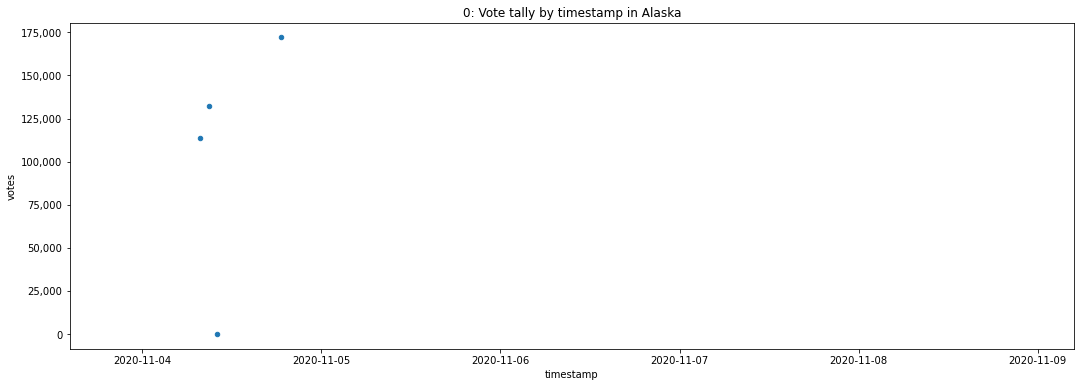

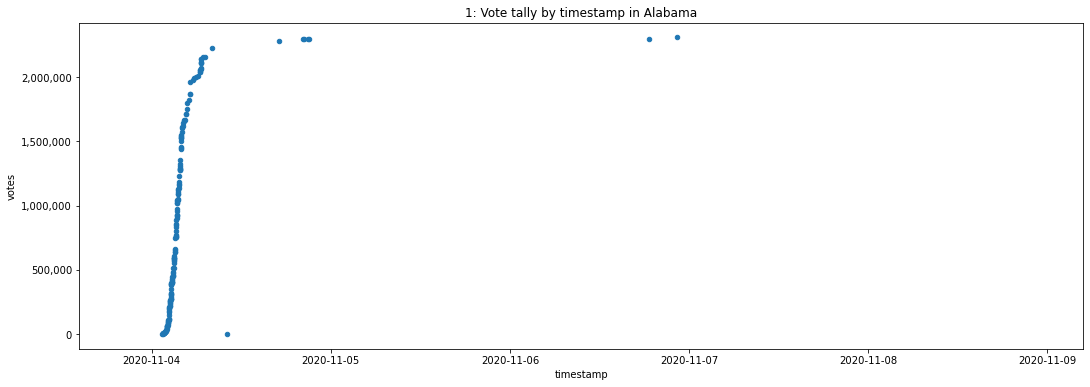

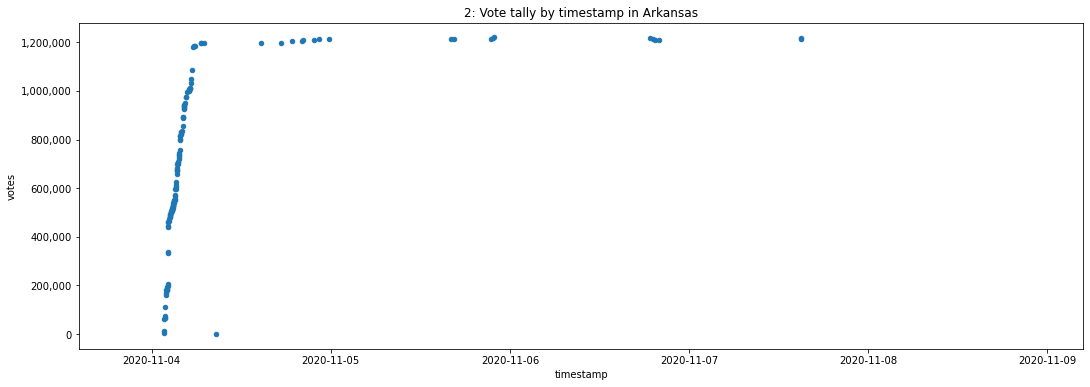

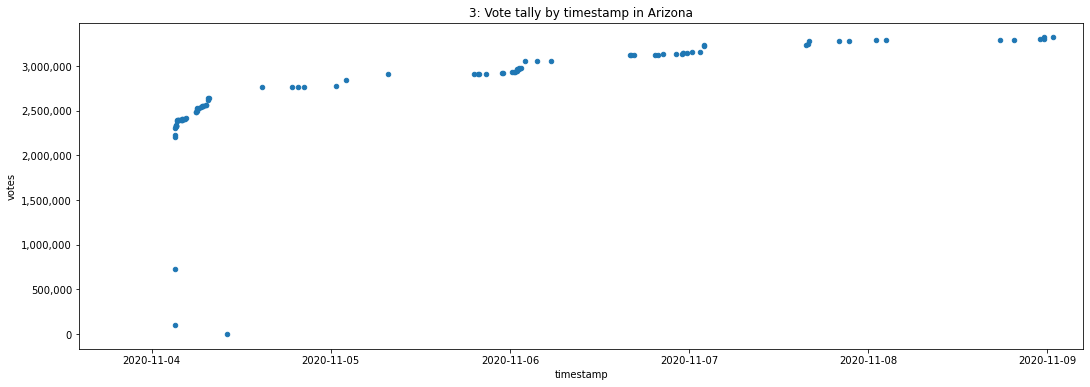

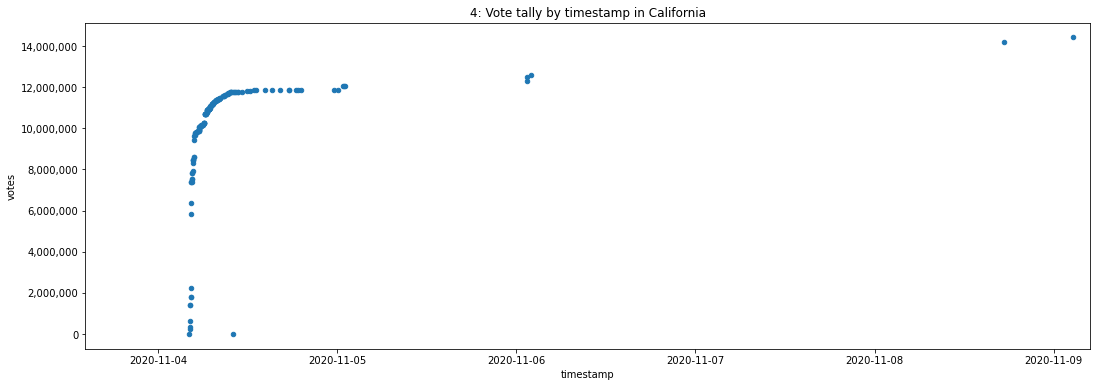

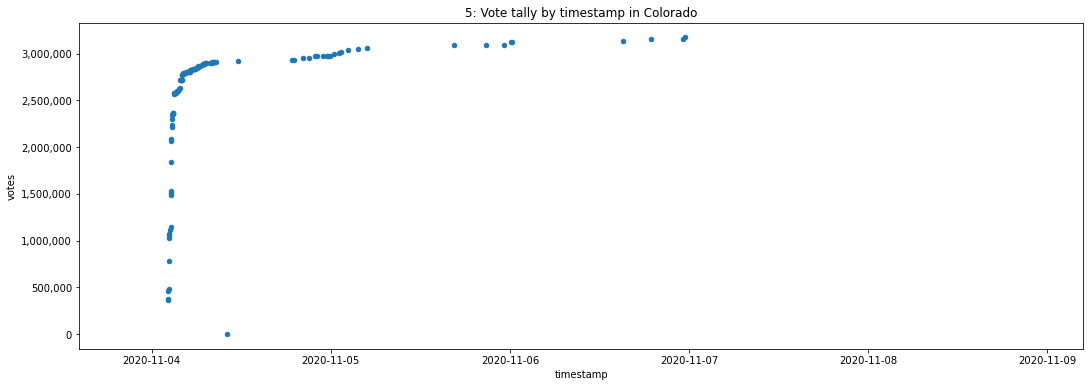

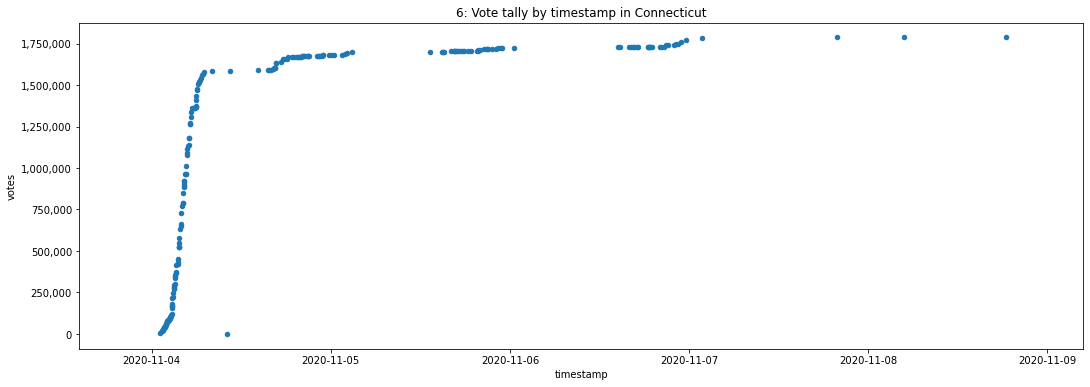

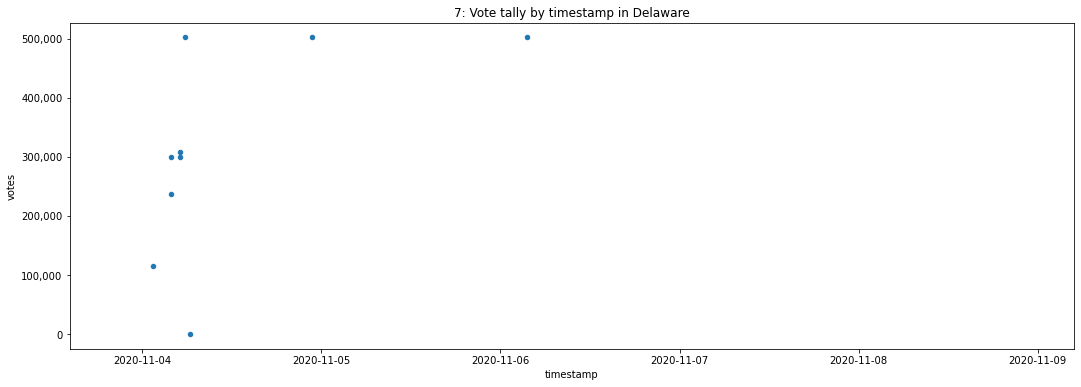

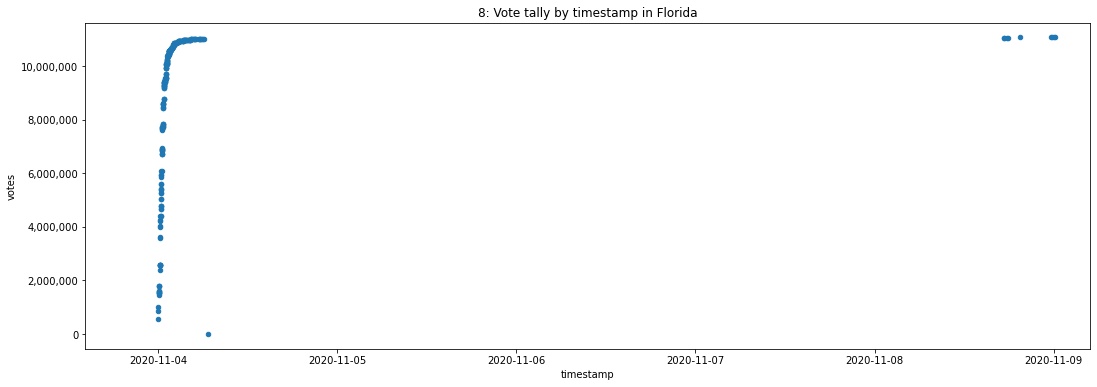

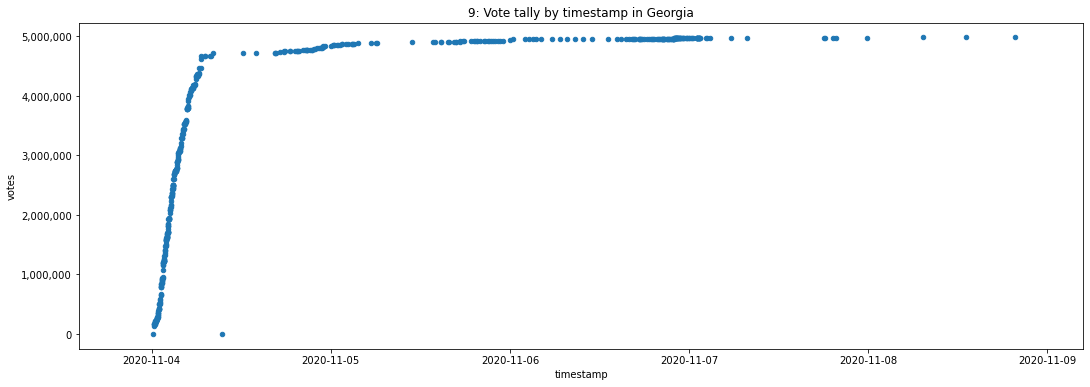

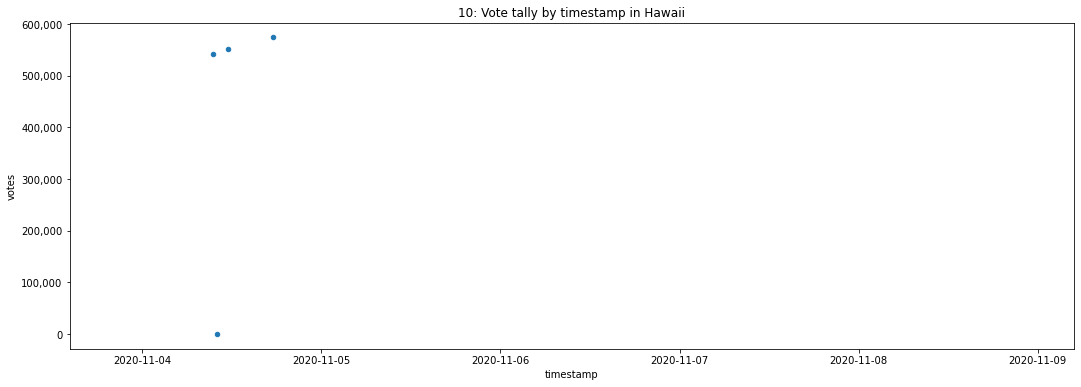

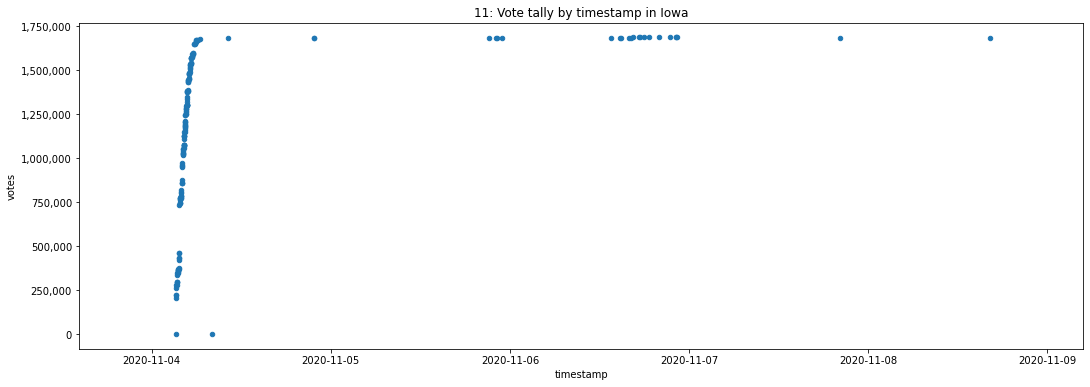

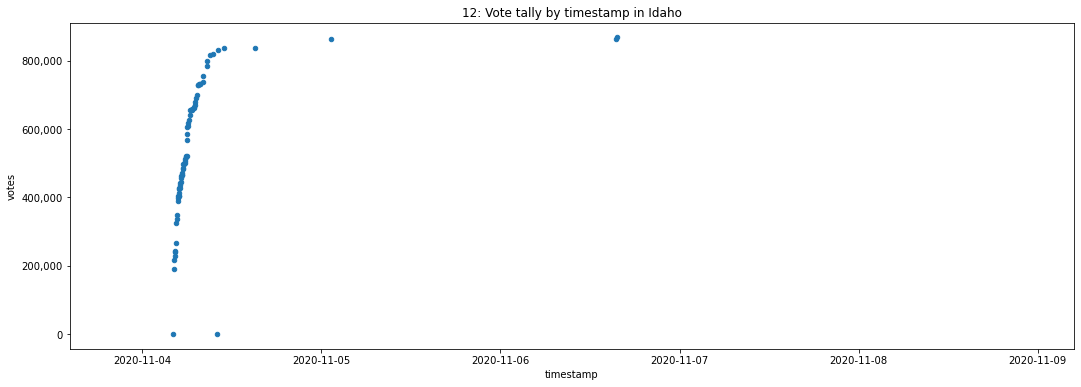

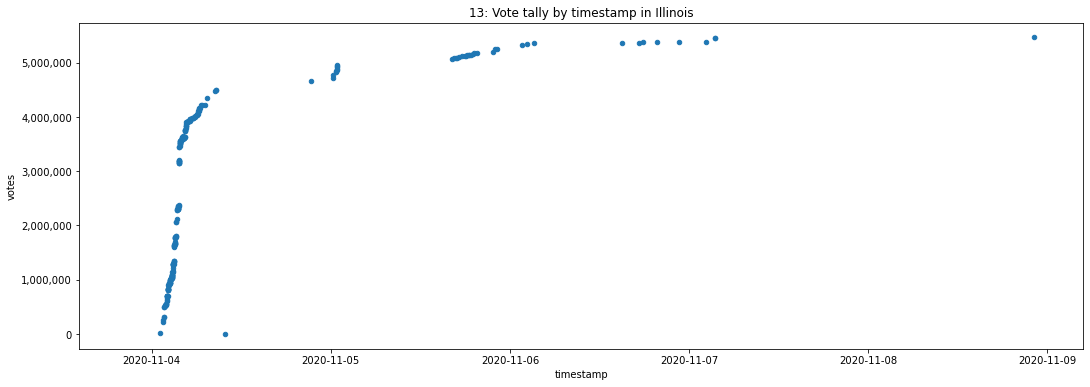

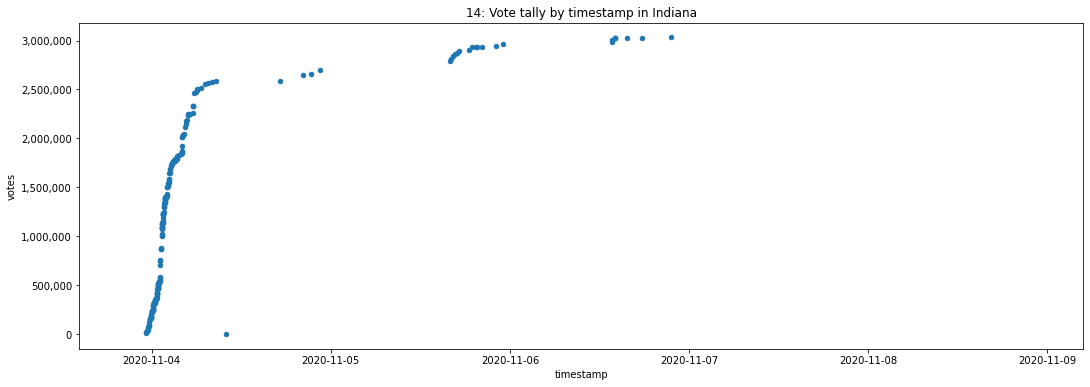

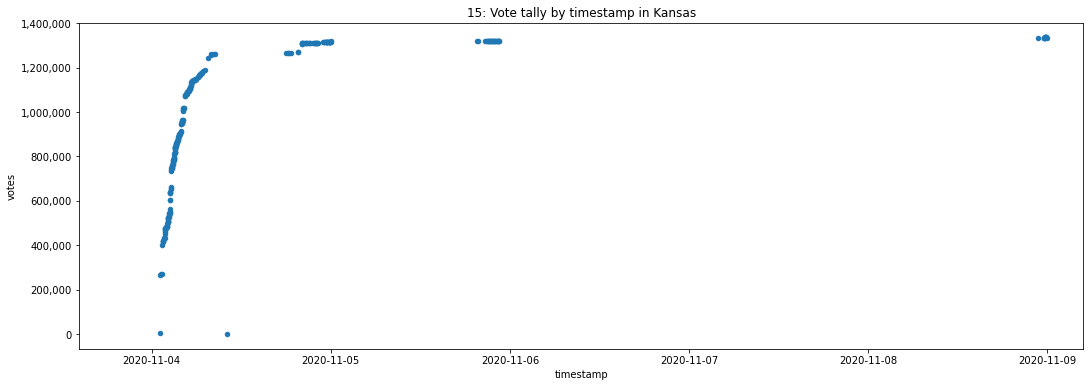

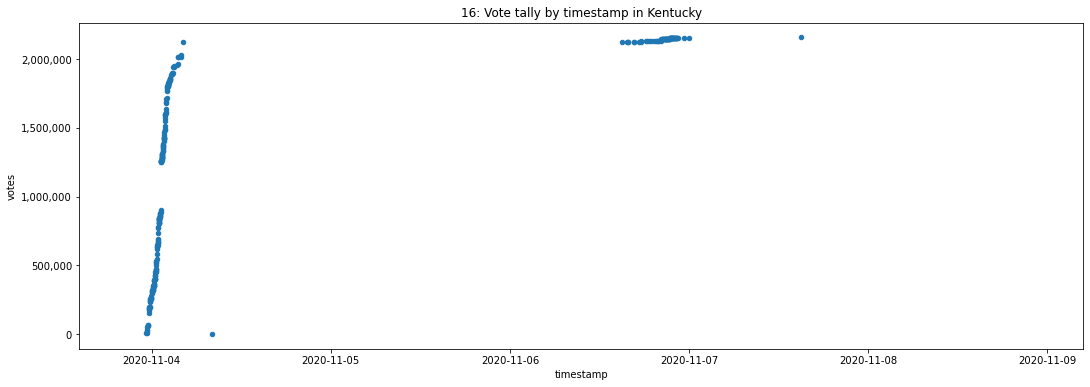

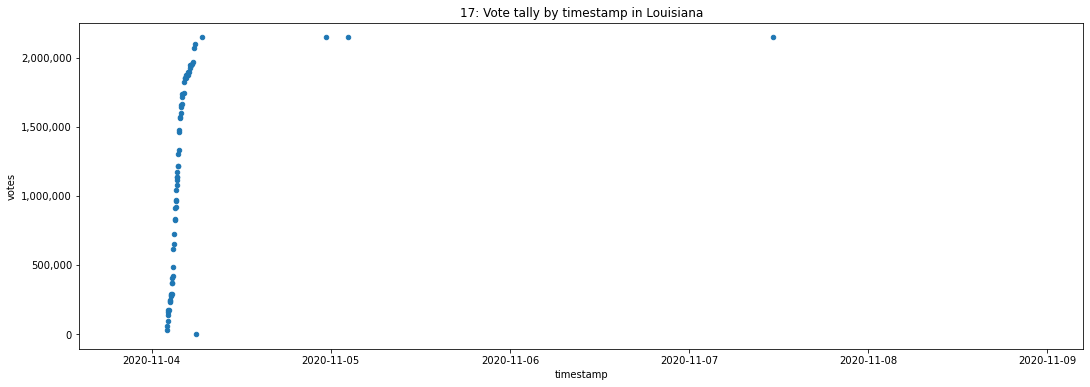

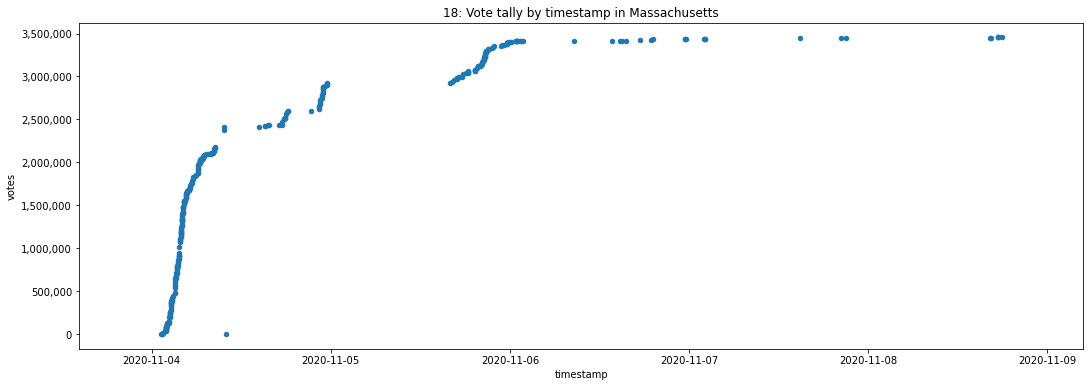

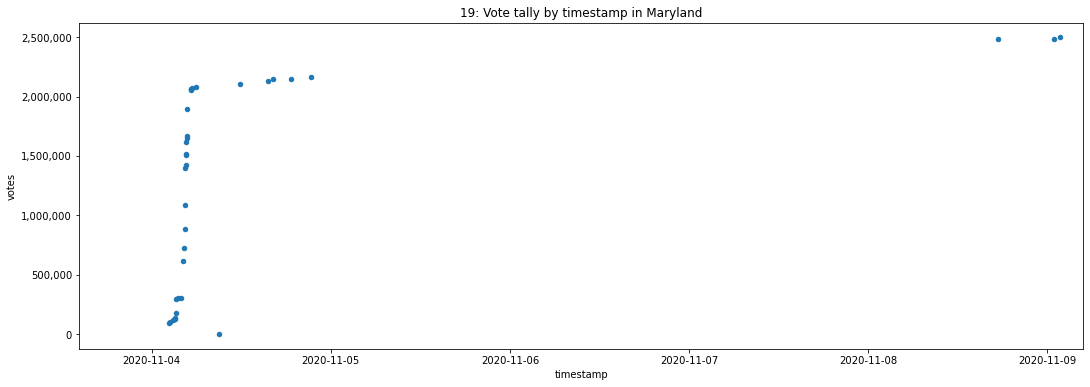

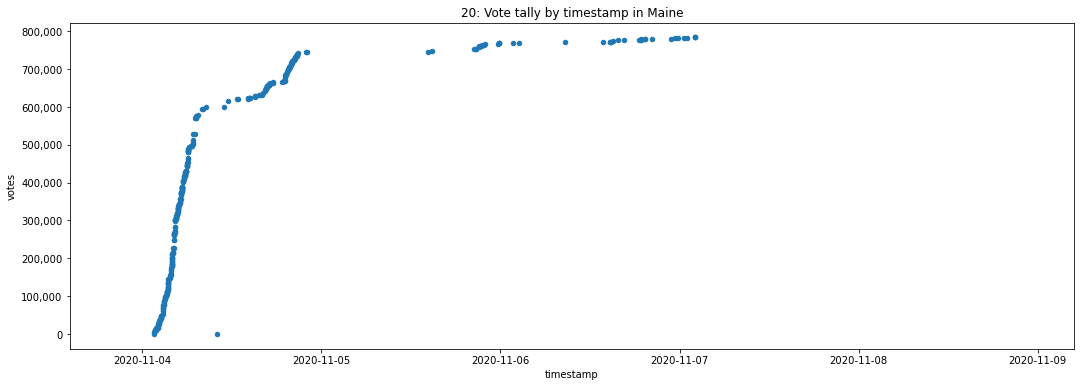

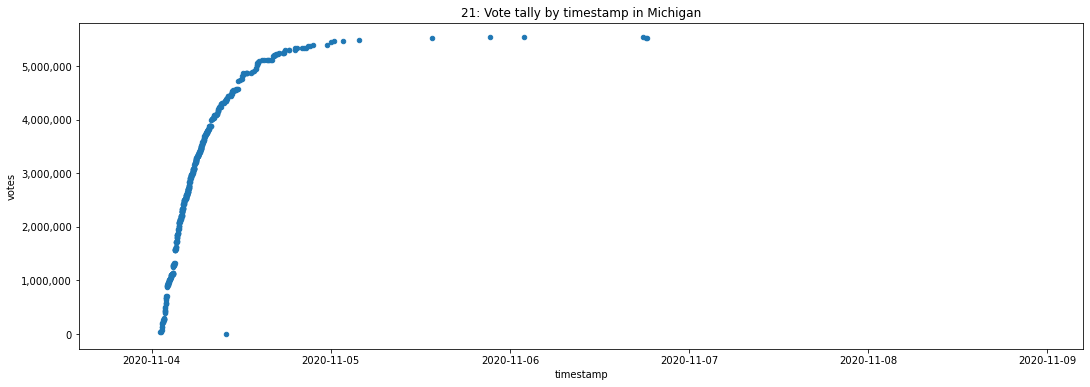

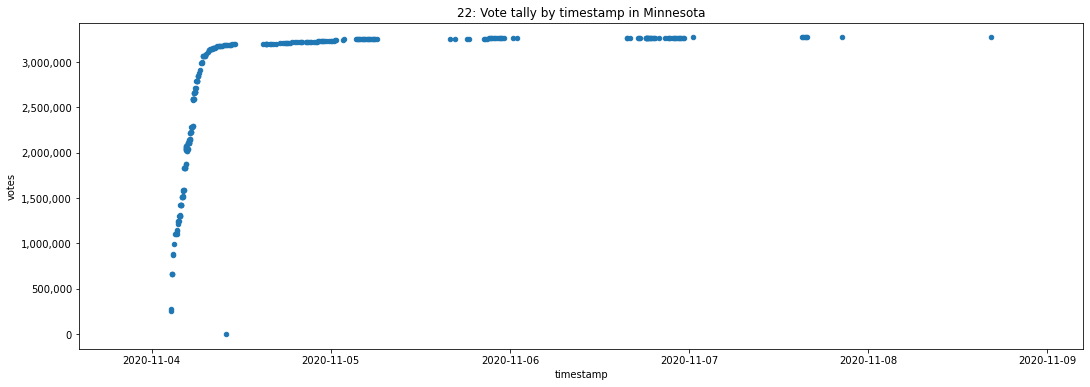

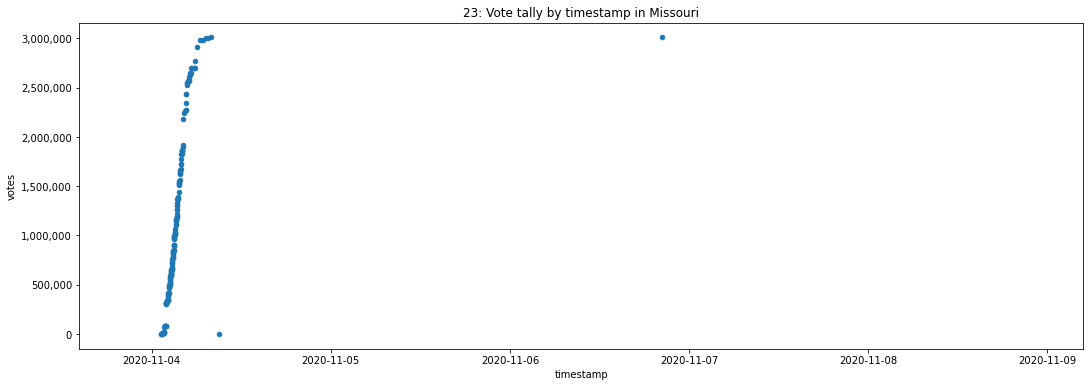

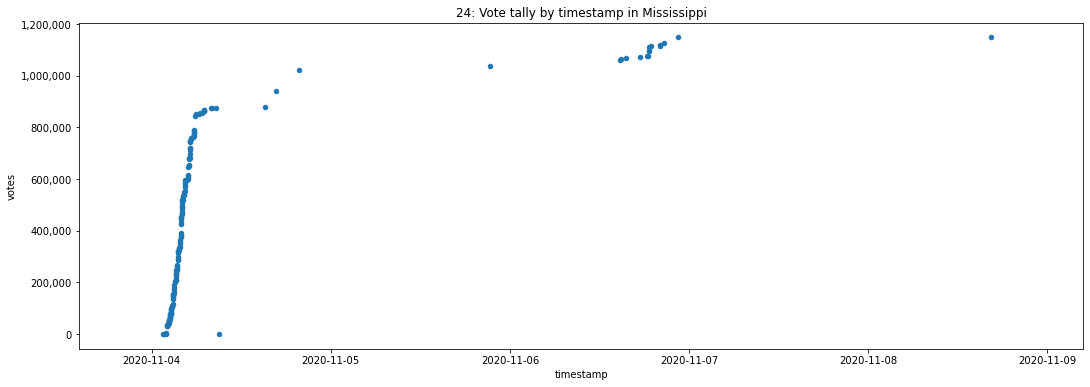

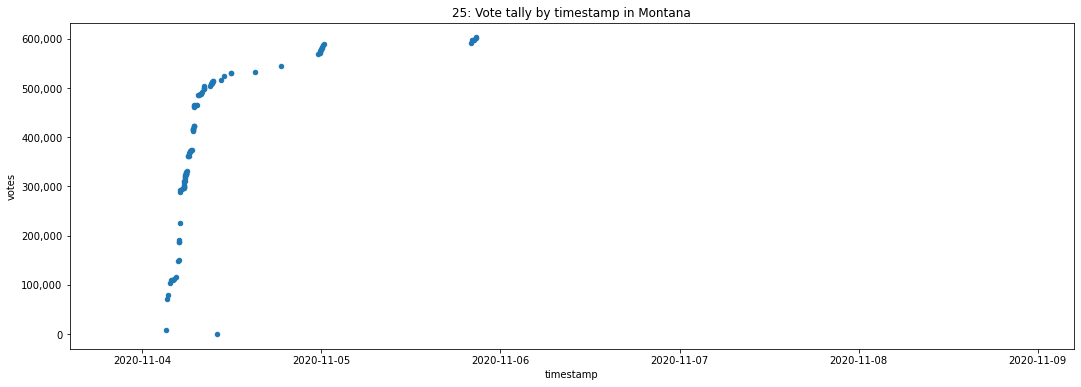

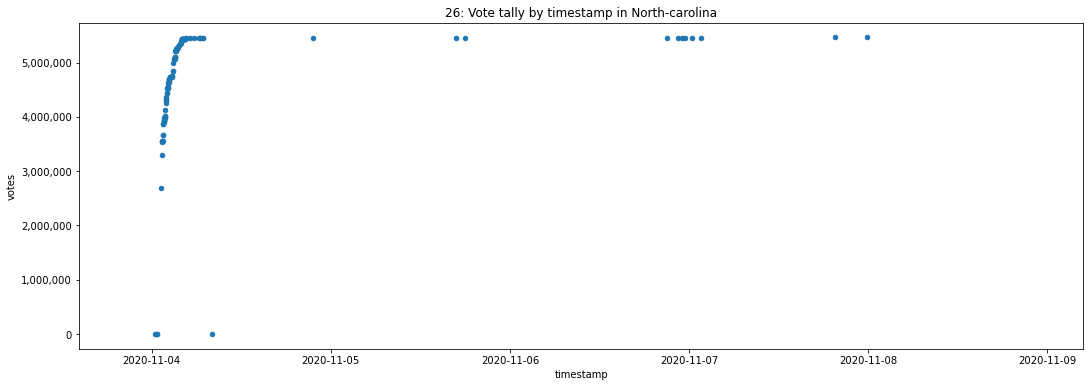

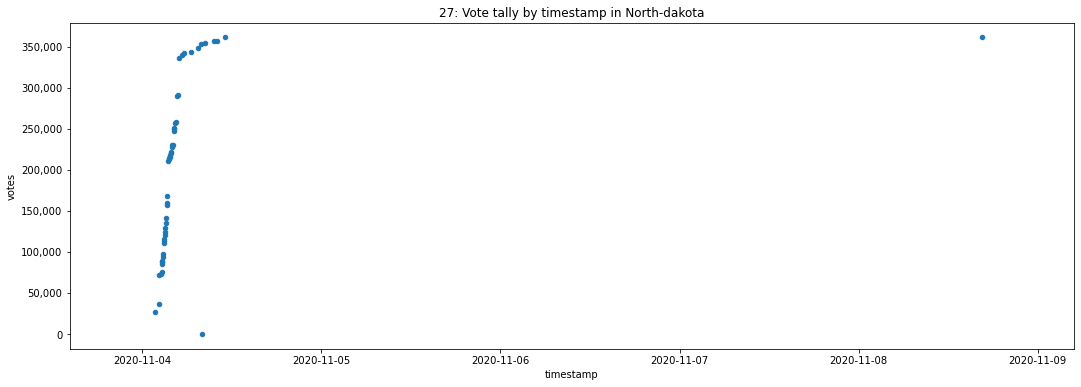

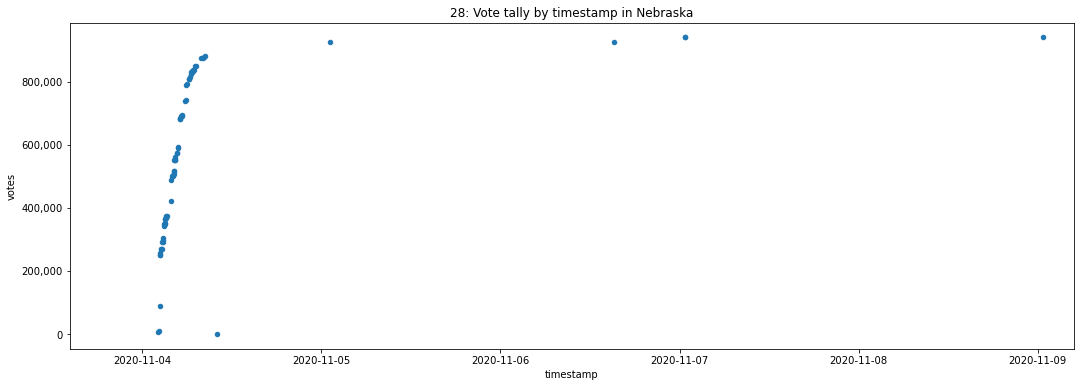

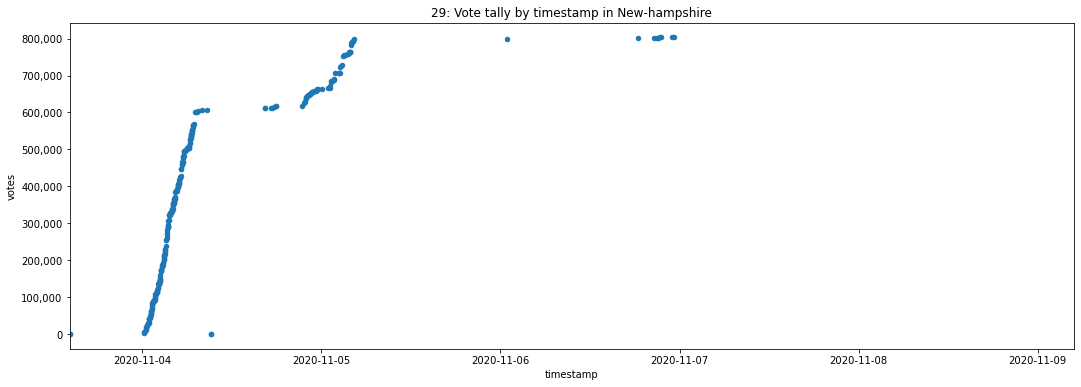

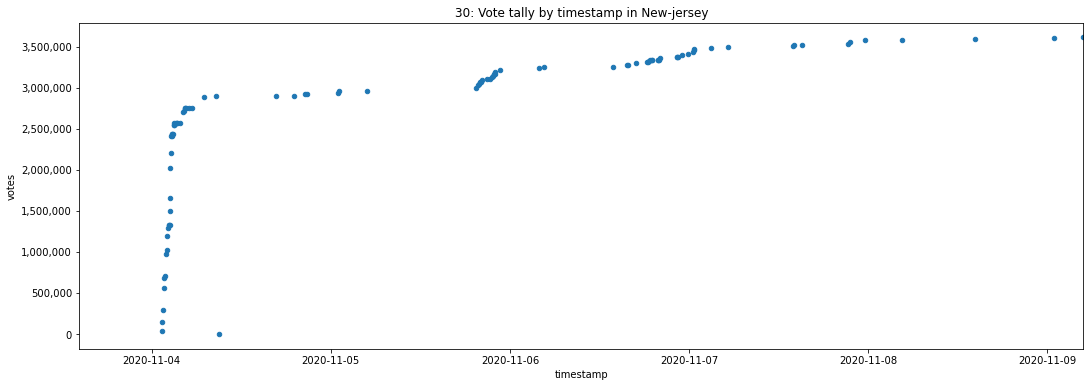

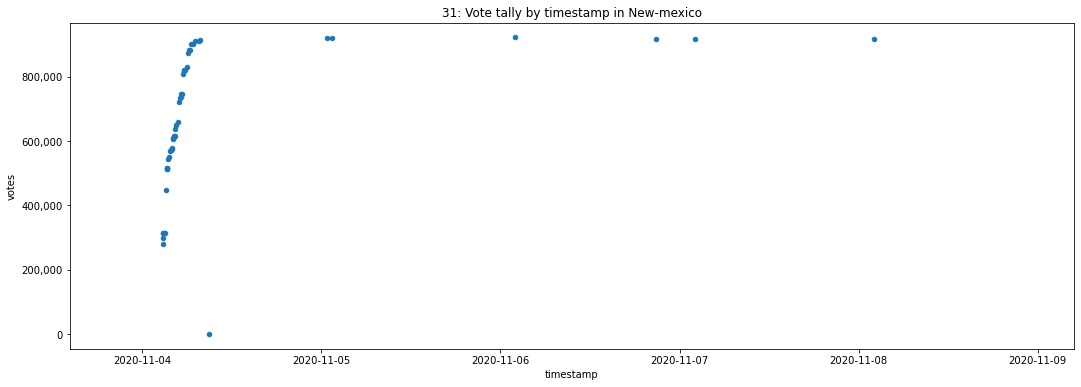

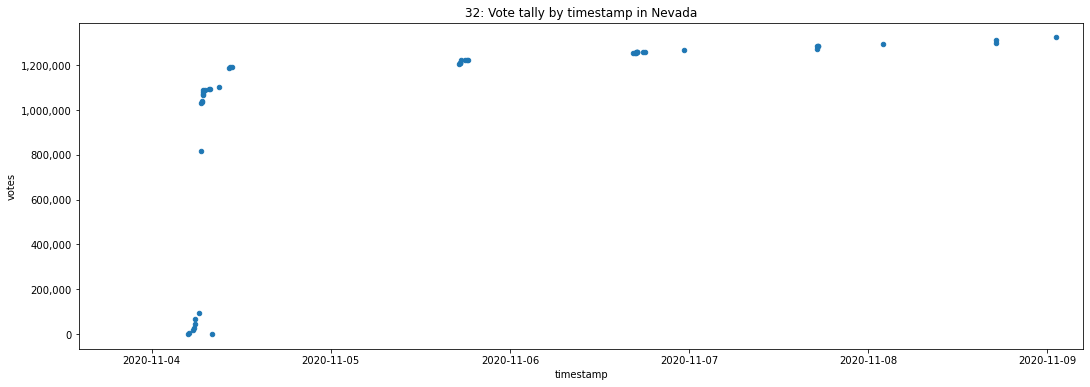

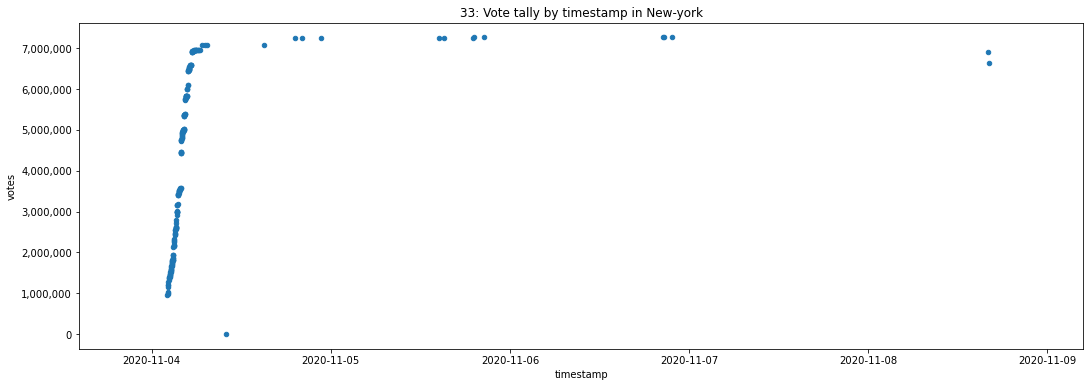

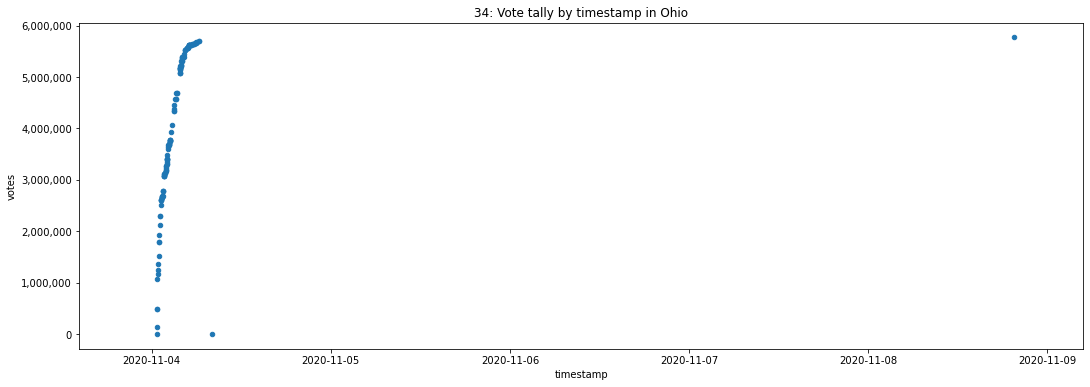

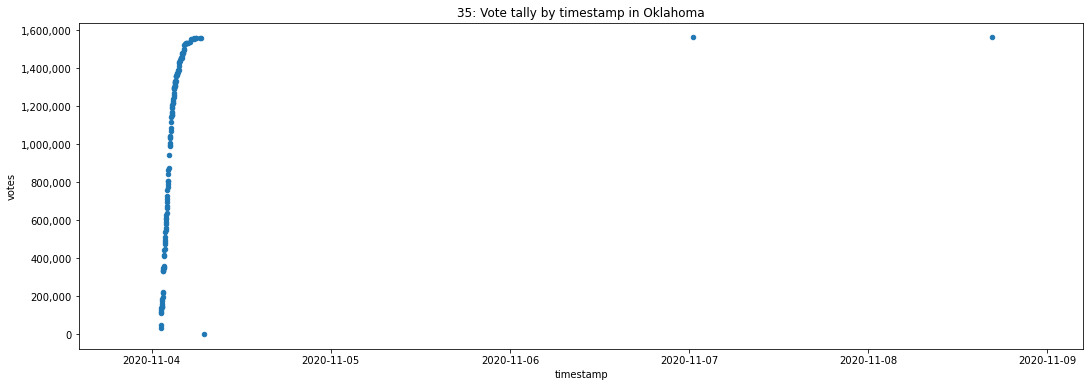

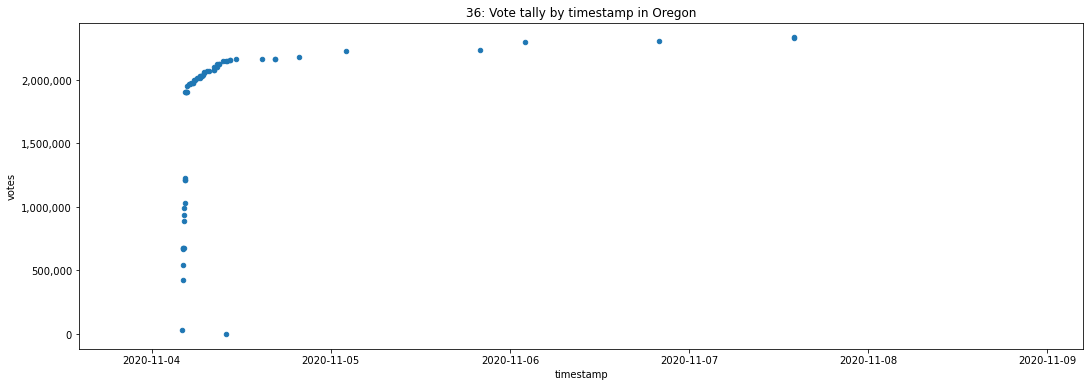

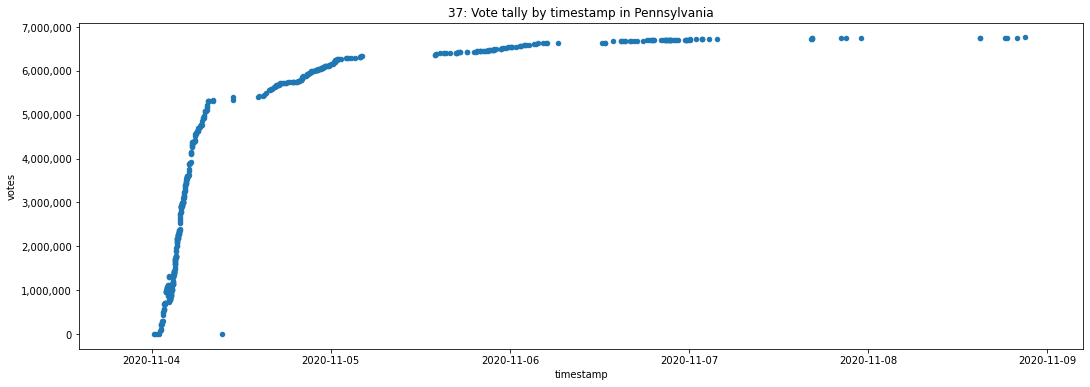

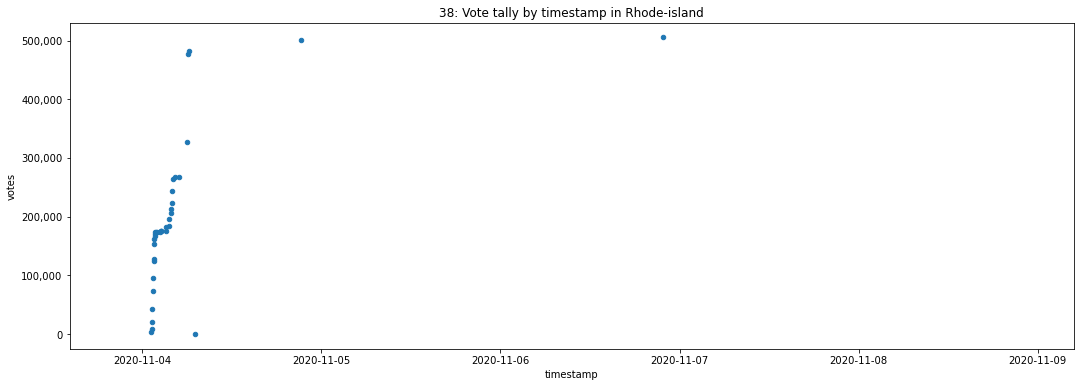

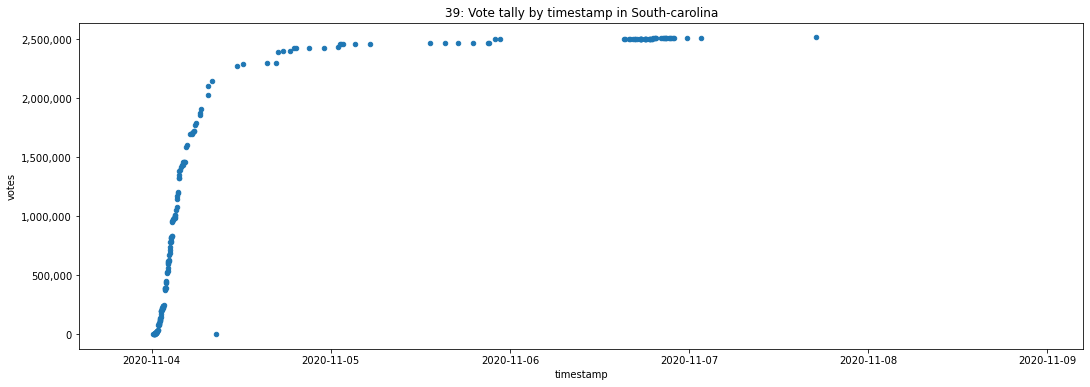

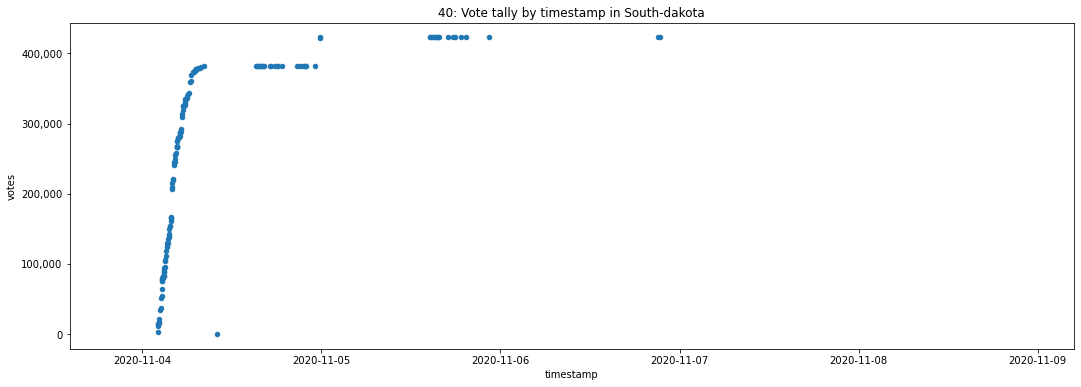

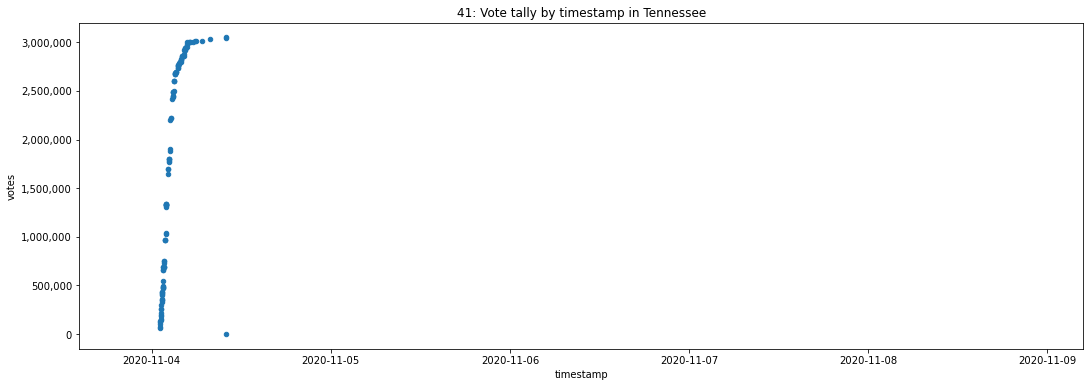

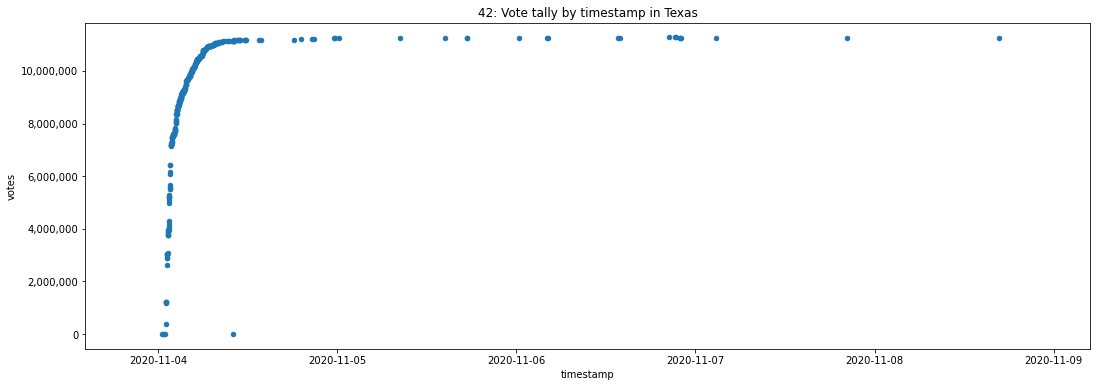

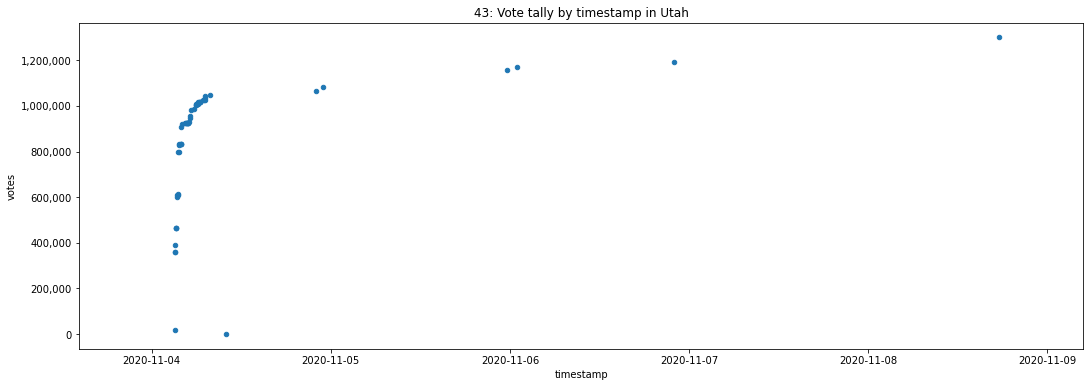

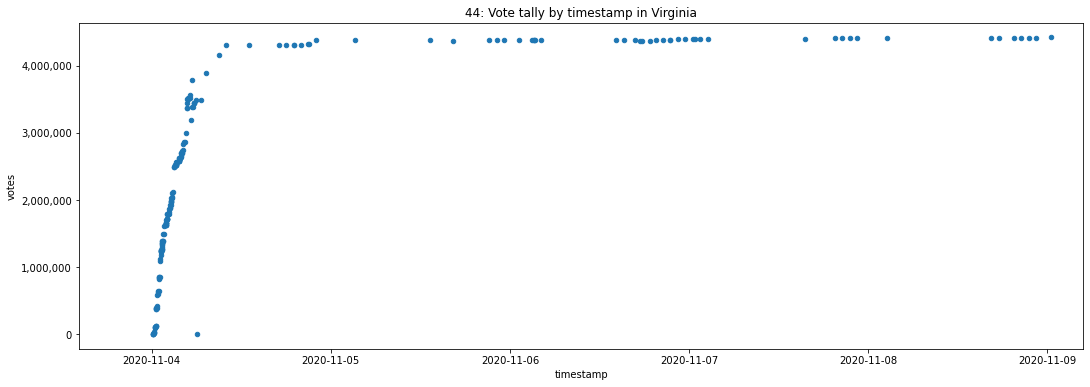

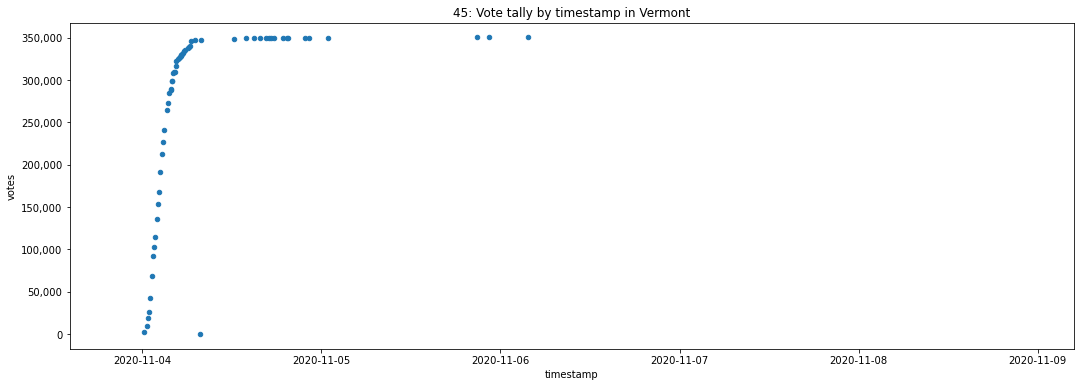

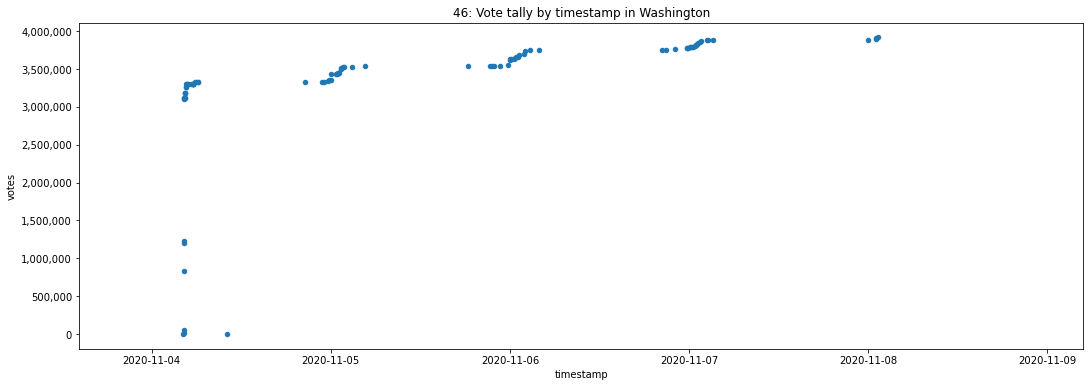

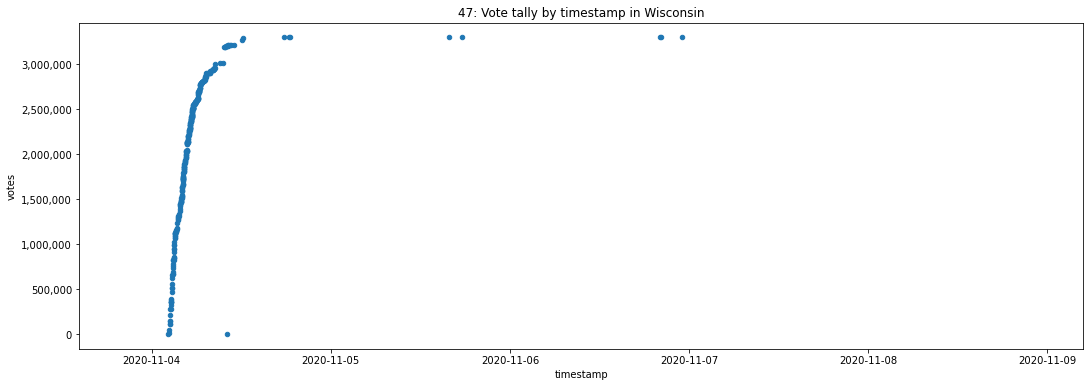

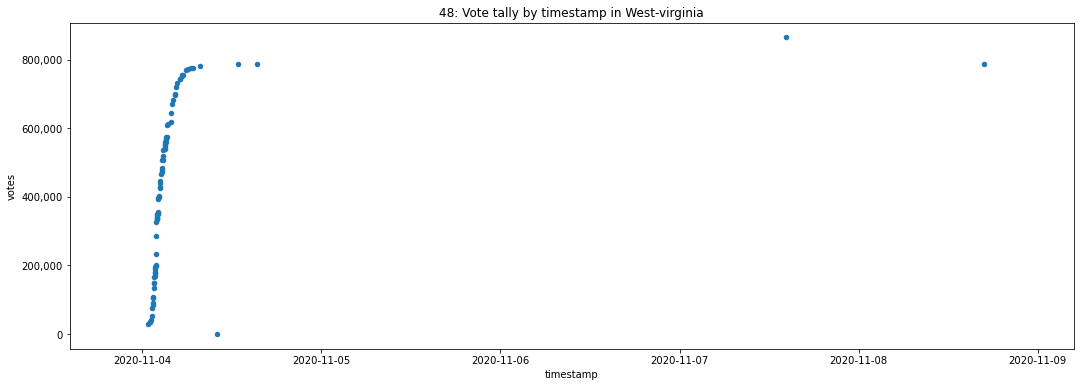

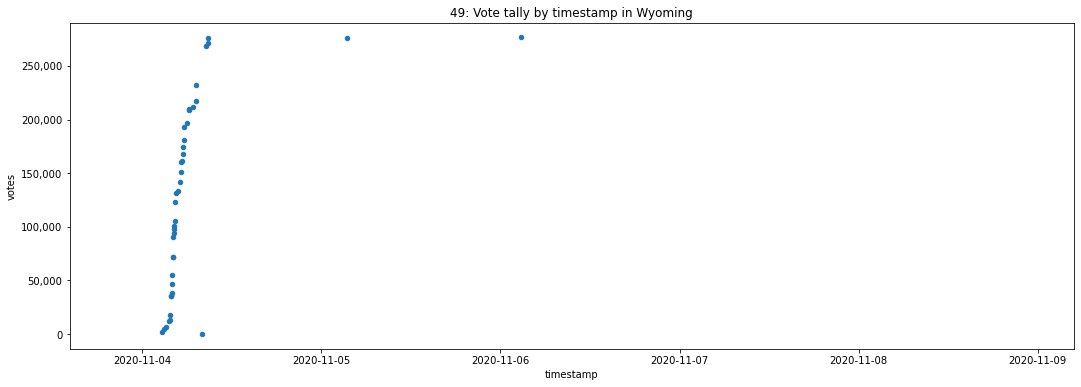

In [11]:
# Create chart distribution: charts will be rendered in pairs
chartDistrib = [ (x, x+1) for x in list(range(len(states))) if x % 2 == 0] 

axes = None
rows_no = 25
# MY_DPI  = 96
MY_DPI  = 1
FIGSIZE = (18/MY_DPI, 6/MY_DPI)

# fig, axes = plt.subplots(nrows=rows_no, ncols=2, figsize=FIGSIZE, dpi=MY_DPI)
# fig.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=None, hspace=None)

# Vote tally by timestamp
for pair in chartDistrib[:rows_no]:
    x0, x1, y = pair[0], pair[1], (int(pair[1]/2))*0
    charts_by_state(axes, resultsByState, 'Vote tally by timestamp', 'timestamp', 'votes', FIGSIZE, x0, x1, y)


    
